In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data


In [ ]:
import pandas as pd

# Replace with your actual folder path in Google Drive
folder_path = '/content/drive/MyDrive/MRP/dataset/'

# Load CSV files
train_df = pd.read_csv(folder_path + 'train_set.csv')
test_df = pd.read_csv(folder_path + 'test_set.csv')

# Separate features and labels
X_train = train_df.drop('Is Laundering', axis=1)
y_train = train_df['Is Laundering']

X_test = test_df.drop('Is Laundering', axis=1)
y_test = test_df['Is Laundering']


# Plot AUC ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the ROC curve and computes AUC for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict or predict_proba method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - auc_value: Computed AUC value.
    """
    # Use predict_proba if available for better ROC results
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_value = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc_value

# Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the Precision-Recall (PR) curve and computes Average Precision (AP) score
    for a given classifier and test data.

    Parameters:
    - model: Trained classifier with a predict_proba or decision_function method.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - model_name: Optional string to label the curve.

    Returns:
    - avg_precision: Computed Average Precision score.
    """
    # Get scores for the positive class
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model must have predict_proba or decision_function method.")

    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    # Plot the PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return avg_precision


# Save Model

In [ ]:
import pickle
import shutil
import os

def save_model(model,model_name, model_id, destination_dir=None):
    """
    Saves a model to a local file and optionally copies it to a destination directory.

    Parameters:
        model: The trained model object to save.
        model_id: An identifier to use in the filename (e.g., an integer or string).
        destination_dir: Optional; directory path to copy the model file to (e.g., Google Drive).

    Returns:
        model_filename (str): The name of the saved model file.
    """
    model_filename = f'{model_name}_model_{model_id}.pkl'

    # Save the model locally
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    # If a destination directory is provided, copy the file there
    if destination_dir:
        # Ensure the destination directory exists
        os.makedirs(destination_dir, exist_ok=True)
        shutil.copy(model_filename, os.path.join(destination_dir, model_filename))

    return model_filename

# save_model(best_model,model_name="Xgboost_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

#Precision Recall Vs Threshold

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(model, X_test, y_test):
    """
    Plots precision and recall against decision thresholds for a classification model.

    Parameters:
    - model: Trained classification model with a predict_proba method.
    - X_test: Feature set to predict on.
    - y_test: True labels for the test set.
    """
    # Get predicted probabilities for positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Remove the last value of precisions and recalls to match the size of thresholds
    precisions = precisions[:-1]
    recalls = recalls[:-1]

    # Plot precision and recall vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.title("Precision and Recall vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# plot_precision_recall_vs_threshold(best_model, X_test, y_test)

# Optimal threshold

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_optimal_threshold(model, X_test, y_test):
    """
    Calculates the optimal threshold for classification based on the highest F1 score.

    Parameters:
    - model: A trained classifier with a `predict_proba` method
    - X_test: Feature set for testing
    - y_test: True labels for testing

    Returns:
    - optimal_threshold: The threshold that yields the highest F1 score
    - precision: Precision at the optimal threshold
    - recall: Recall at the optimal threshold
    - f1: F1 score at the optimal threshold
    """
    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Compute F1 scores and find the best threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_index = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_index]

    precision = precisions[best_index]
    recall = recalls[best_index]
    f1 = f1_scores[best_index]

    print(f"Best Threshold: {optimal_threshold:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    return optimal_threshold, precision, recall, f1

# threshold, precision, recall, f1 = find_optimal_threshold(best_model, X_test, y_test)



# LightGbm

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime
import lightgbm as lgb

def train_lightgbm_aml_model( X_train,y_train,X_test,y_test,scale_pos_weight=100):
    """
    Trains an XGBoost classifier for Anti-Money Laundering detection.

    Parameters:

    - scale_pos_weight (int): Class imbalance adjustment for positive class (default is 100).

    Returns:
    - classification report as DataFrame
    - trained XGBoost model
    """

    model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=100,
    random_state=42
    )

    t0 = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_time_secs = (datetime.now() - t0).seconds

    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, model,training_time_secs

report_df, model, training_time= train_lightgbm_aml_model( X_train,y_train,X_test,y_test,scale_pos_weight=100)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3624, number of negative: 3551217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1627
[LightGBM] [Info] Number of data points in the train set: 3554841, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001019 -> initscore=-6.887467
[LightGBM] [Info] Start training from score -6.887467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
report_df


,precision,recall,f1-score,support
0,0.999425,0.947458,0.972748,1.521951e+06
1,0.008960,0.465551,0.017582,1.553000e+03
accuracy,0.946967,0.946967,0.946967,9.469670e-01
macro avg,0.504193,0.706504,0.495165,1.523504e+06
weighted avg,0.998415,0.946967,0.971774,1.523504e+06


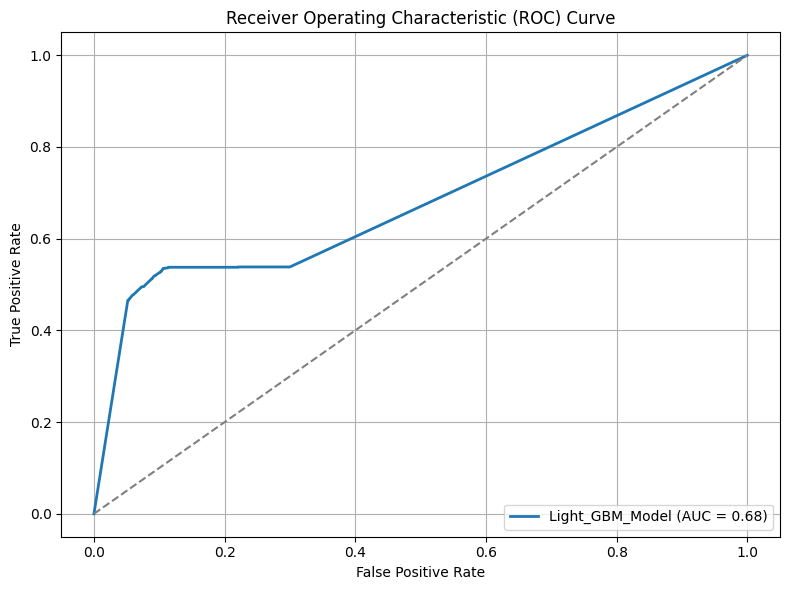

np.float64(0.6819955896130768)

In [ ]:
plot_roc_curve(model, X_test, y_test, model_name='Light_GBM_Model')

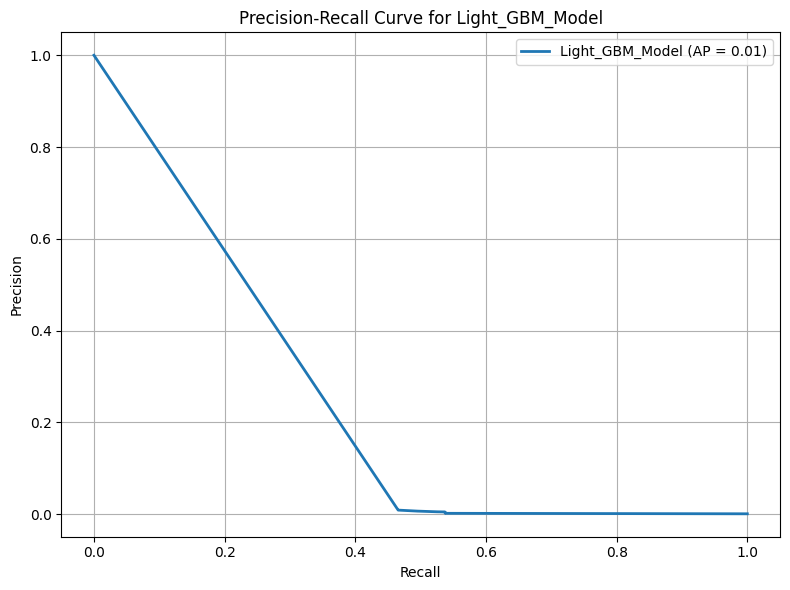

np.float64(0.005172658152591421)

In [ ]:
plot_precision_recall_curve(model, X_test, y_test, model_name='Light_GBM_Model')

# Tune LightGBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import lightgbm as lgb

def tune_lightgbm_model(X_train, y_train, X_test, y_test, n_iter=10, random_state=42):
    """
    Tunes a LightGBM model using RandomizedSearchCV.

    Parameters:
    - X_train, y_train: Training features and labels
    - X_test, y_test: Testing features and labels
    - n_iter (int): Number of parameter settings sampled (default: 10)
    - random_state (int): Seed for reproducibility

    Returns:
    - report_df: Classification report as DataFrame
    - best_model: Best LightGBM model after tuning
    - best_params: Best hyperparameters found
    """

    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'scale_pos_weight': [50, 75, 100, 150]
    }

    lgb_clf = lgb.LGBMClassifier(random_state=random_state)

    rand_search = RandomizedSearchCV(
        lgb_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    t0 = datetime.now()
    rand_search.fit(X_train, y_train)
    best_model = rand_search.best_estimator_
    best_params = rand_search.best_params_
    training_time_secs = (datetime.now() - t0).seconds

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, best_model, best_params,training_time_secs

In [ ]:
report_df, best_model, best_params, training_time_secs = tune_lightgbm_model(X_train, y_train, X_test, y_test, n_iter=10, random_state=42)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3624, number of negative: 3551217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.640078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1627
[LightGBM] [Info] Number of data points in the train set: 3554841, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001019 -> initscore=-6.887467
[LightGBM] [Info] Start training from score -6.887467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
print("Best Hyperparameters:\n",best_params)
print("report_df:\n",report_df)
print("training_time_secs\n",training_time_secs)

Best Hyperparameters:
 {'colsample_bytree': np.float64(0.7783331011414365), 'learning_rate': np.float64(0.039992474745400866), 'max_depth': 5, 'n_estimators': 137, 'scale_pos_weight': 50, 'subsample': np.float64(0.8404460046972835)}
report_df:
               precision    recall  f1-score       support
0              0.999437  0.995989  0.997710  1.521951e+06
1              0.102734  0.450097  0.167285  1.553000e+03
accuracy       0.995432  0.995432  0.995432  9.954322e-01
macro avg      0.551085  0.723043  0.582497  1.523504e+06
weighted avg   0.998523  0.995432  0.996863  1.523504e+06
training_time_secs
 839


In [ ]:
save_model(best_model,model_name="lightGbm_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

'lightGbm_tuned_model_1.pkl'

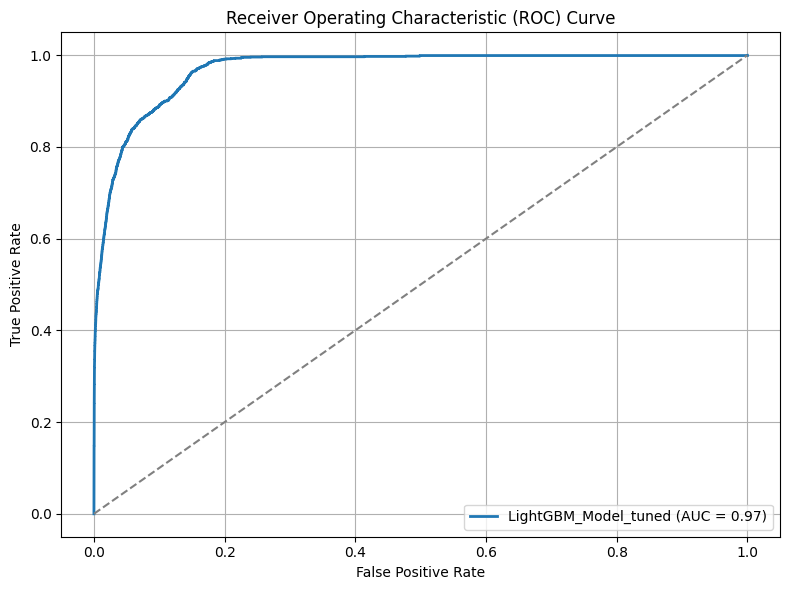

np.float64(0.9696581858769263)

In [ ]:
plot_roc_curve(best_model, X_test, y_test, model_name='LightGBM_Model_tuned')

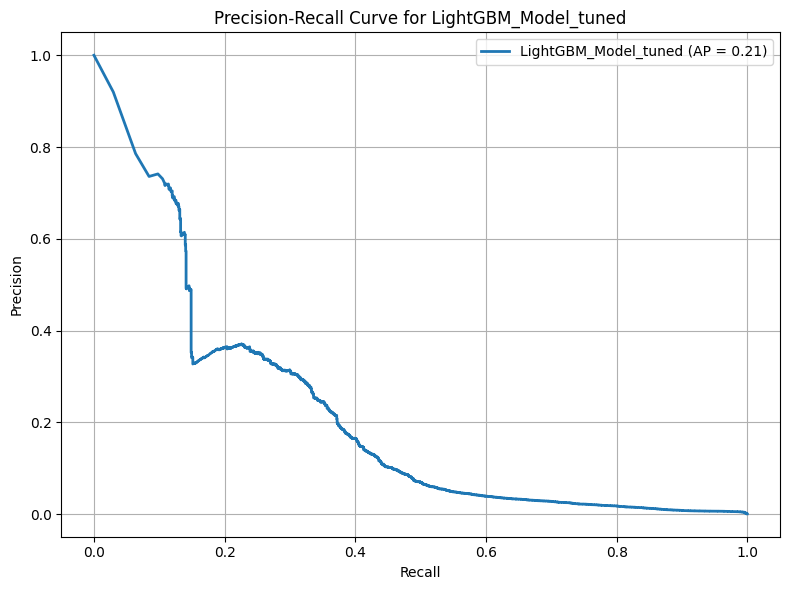

np.float64(0.21255646601633915)

In [ ]:
plot_precision_recall_curve(best_model, X_test, y_test, model_name='LightGBM_Model_tuned')

In [ ]:
threshold, precision, recall, f1 = find_optimal_threshold(best_model, X_test, y_test)

Best Threshold: 0.71
Precision: 0.30, Recall: 0.31, F1: 0.31


# CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
# Re-import required libraries and install CatBoost after reset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from datetime import datetime

# Load and preprocess dataset
# file_path = '/mnt/data/sample_data.csv'
file_path = '/content/drive/MyDrive/MRP/dataset/HI-Small_Trans.csv'
data = pd.read_csv(file_path)

df = data.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df.drop(columns=['Timestamp', 'Receiving Currency', 'Payment Currency'], inplace=True)

categorical_cols = ['From Bank', 'Account', 'To Bank', 'Account.1', 'Payment Format']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# # Downsample
df_sample = df.sample(frac=0.1, random_state=42)
X = df_sample.drop(columns=['Is Laundering'])
y = df_sample['Is Laundering']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# # Identify categorical feature indices
# cat_features = [X.columns.get_loc(col) for col in categorical_cols]

# # Train CatBoost model
# cat_model = CatBoostClassifier(
#     iterations=200,
#     learning_rate=0.1,
#     depth=6,
#     scale_pos_weight=100,
#     random_seed=42,
#     verbose=0
# )
# t0 = datetime.now()
# cat_model.fit(X_train, y_train, cat_features=cat_features)
# training_time_secs = (datetime.now() - t0).seconds


# # Evaluate model
# y_pred = cat_model.predict(X_test)
# report = classification_report(y_test, y_pred, output_dict=True)
# report_df = pd.DataFrame(report).transpose()


# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from catboost import CatBoostClassifier
# from datetime import datetime
# import pandas as pd

def train_evaluate_catboost(X, y, categorical_cols, test_size=0.2, random_state=42,
                            iterations=200, learning_rate=0.1, depth=6, scale_pos_weight=100):
    """
    Train and evaluate a CatBoostClassifier on the given dataset.

    Parameters:
    - X: pd.DataFrame - Feature matrix
    - y: pd.Series or np.array - Target vector
    - categorical_cols: list - List of categorical column names
    - test_size: float - Proportion of dataset to include in the test split
    - random_state: int - Random seed for reproducibility
    - iterations: int - Number of boosting iterations
    - learning_rate: float - Learning rate
    - depth: int - Depth of each tree
    - scale_pos_weight: float - Balancing of positive and negative weights

    Returns:
    - cat_model: Trained CatBoostClassifier model
    - report_df: pd.DataFrame - Classification report
    - training_time_secs: int - Training time in seconds
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Identify categorical feature indices
    cat_features = [X.columns.get_loc(col) for col in categorical_cols]

    # Train CatBoost model
    cat_model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        scale_pos_weight=scale_pos_weight,
        random_seed=random_state,
        verbose=0
    )

    t0 = datetime.now()
    cat_model.fit(X_train, y_train, cat_features=cat_features)
    training_time_secs = (datetime.now() - t0).seconds

    # Evaluate model
    y_pred = cat_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return cat_model, report_df, training_time_secs




In [ ]:

model,report_df, training_time= train_evaluate_catboost(X, y, categorical_cols, test_size=0.2, random_state=42,
                            iterations=200, learning_rate=0.1, depth=6, scale_pos_weight=100)

,precision,recall,f1-score,support
0,0.999681,0.988528,0.994073,101461.000000
1,0.059774,0.698113,0.110119,106.000000
accuracy,0.988225,0.988225,0.988225,0.988225
macro avg,0.529727,0.843320,0.552096,101567.000000
weighted avg,0.998700,0.988225,0.993151,101567.000000


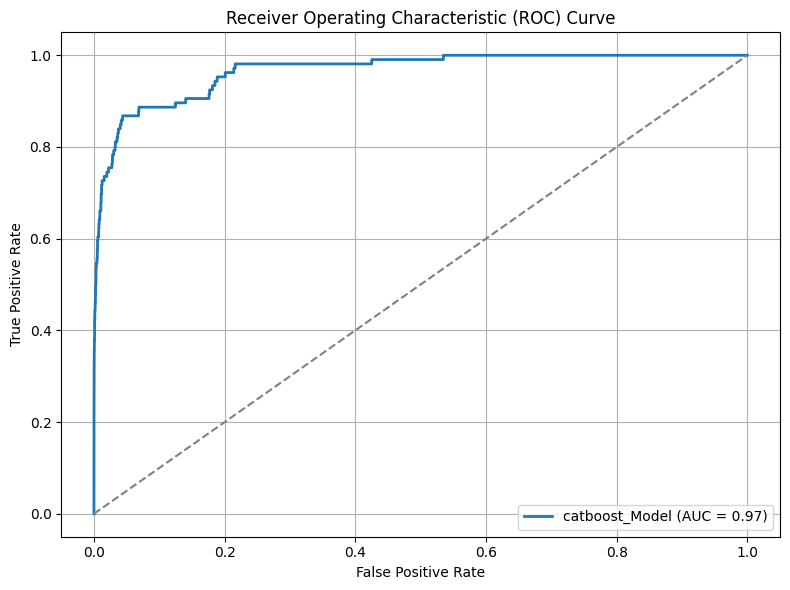

np.float64(0.9662695007078657)

In [ ]:
plot_roc_curve(model, X_test, y_test, model_name='catboost_Model')

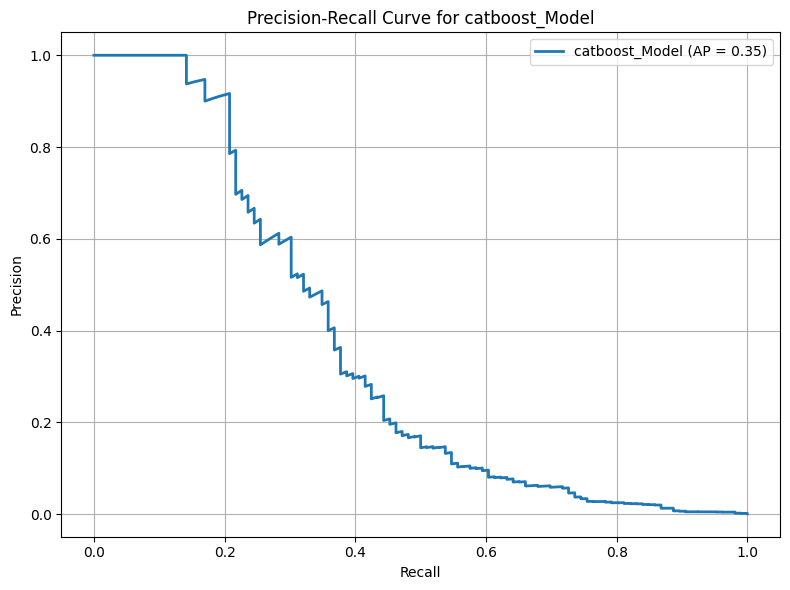

np.float64(0.35451644152138934)

In [ ]:
plot_precision_recall_curve(model, X_test, y_test, model_name='catboost_Model')

In [ ]:
threshold, precision, recall, f1 = find_optimal_threshold(model, X_test, y_test)

Best Threshold: 0.89
Precision: 0.49, Recall: 0.35, F1: 0.41


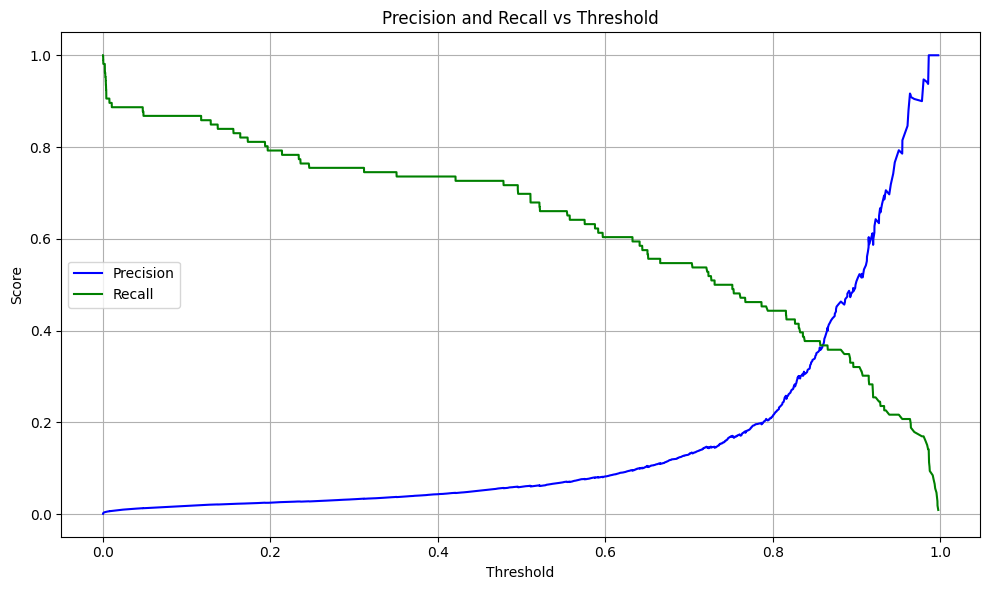

In [ ]:
plot_precision_recall_vs_threshold(model, X_test, y_test)

# Catboost Hyper parameter Training


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from datetime import datetime
import pandas as pd

def tune_catboost_hyperparameters(X_train, y_train, X_test, y_test, categorical_cols,
                                  n_iter=10, random_state=42):
    """
    Performs hyperparameter tuning on a CatBoost classifier using RandomizedSearchCV.

    Parameters:
    - X_train, y_train: Training features and labels
    - X_test, y_test: Testing features and labels
    - categorical_cols: List of categorical feature column names
    - n_iter (int): Number of parameter settings sampled
    - random_state (int): Seed for reproducibility

    Returns:
    - report_df: DataFrame of the classification report for the best model
    - best_model: The best CatBoost model after tuning
    - best_params: Dictionary of the best hyperparameters
    - training_time_secs: Time taken for training in seconds
    """

    cat_features = [X_train.columns.get_loc(col) for col in categorical_cols]

    param_dist = {
        'iterations': randint(100, 300),
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.3),
        'l2_leaf_reg': uniform(1, 10),
        'scale_pos_weight': [50, 75, 100, 150]
    }

    cat_clf = CatBoostClassifier(
        cat_features=cat_features,
        random_seed=random_state,
        verbose=0
    )

    rand_search = RandomizedSearchCV(
        estimator=cat_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )

    t0 = datetime.now()
    rand_search.fit(X_train, y_train)
    training_time_secs = (datetime.now() - t0).seconds

    best_model = rand_search.best_estimator_
    best_params = rand_search.best_params_

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df, best_model, best_params, training_time_secs


In [ ]:
report_df, best_model, best_params, training_time_secs=tune_catboost_hyperparameters(X_train, y_train, X_test, y_test,categorical_cols, n_iter=10, random_state=42)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print("Best Hyperparameters:\n",best_params)
print("report_df:\n",report_df)
print("training_time_secs\n",training_time_secs)

Best Hyperparameters:
 {'depth': 6, 'iterations': 269, 'l2_leaf_reg': np.float64(1.4666566321361543), 'learning_rate': np.float64(0.30212665565243774), 'scale_pos_weight': 100}
report_df:
               precision    recall  f1-score        support
0              0.999407  0.995959  0.997680  101461.000000
1              0.100877  0.433962  0.163701     106.000000
accuracy       0.995373  0.995373  0.995373       0.995373
macro avg      0.550142  0.714961  0.580690  101567.000000
weighted avg   0.998469  0.995373  0.996809  101567.000000
training_time_secs
 1559


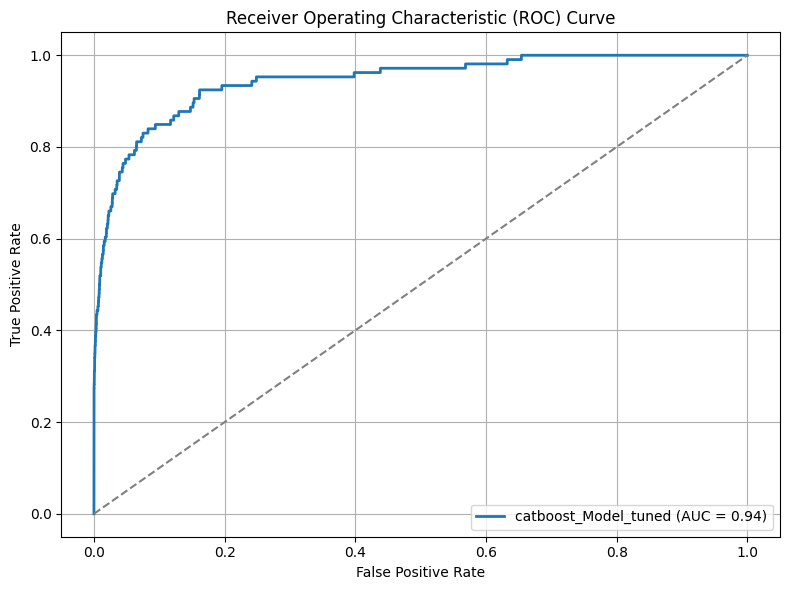

np.float64(0.9446920119692798)

In [ ]:
plot_roc_curve(best_model, X_test, y_test, model_name='catboost_Model_tuned')

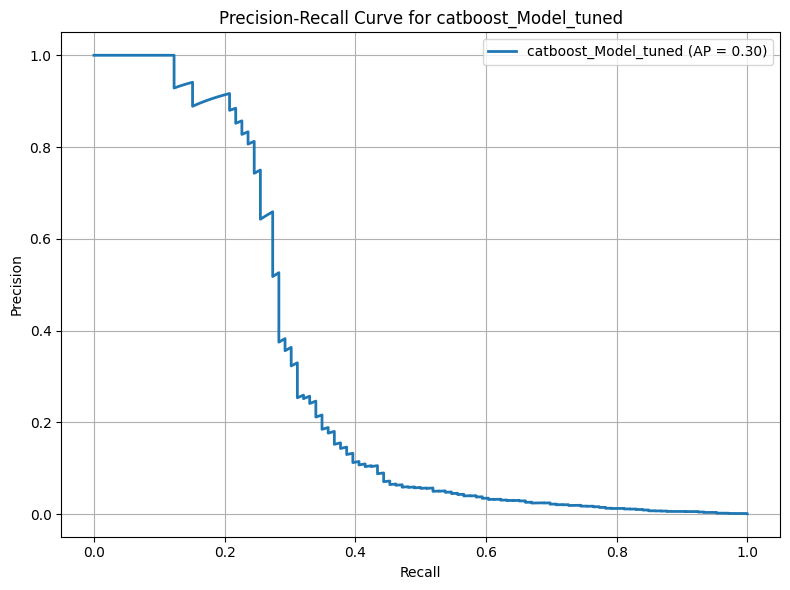

np.float64(0.30298126467006636)

In [ ]:
plot_precision_recall_curve(best_model, X_test, y_test, model_name='catboost_Model_tuned')

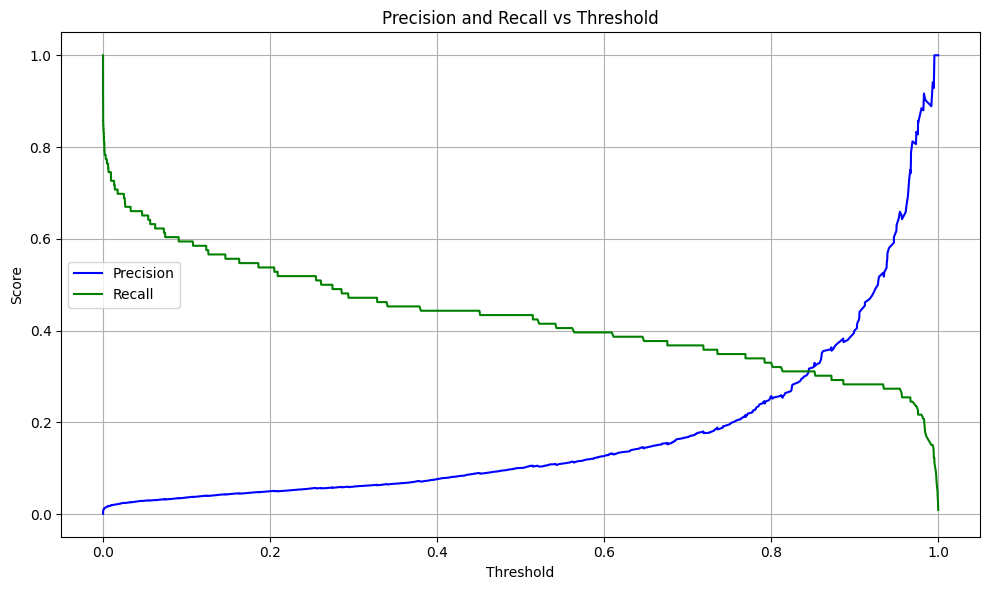

In [ ]:
plot_precision_recall_vs_threshold(best_model, X_test, y_test)

In [ ]:
save_model(best_model,model_name="catboost_Model_tuned", model_id=1, destination_dir='/content/drive/MyDrive/MRP/model')

'catboost_Model_tuned_model_1.pkl'